In [1]:
%pip install torchbnn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
# import scipy.stats as st
import torchbnn as bnn
import torch.nn as nn
import seaborn as sns
import pandas as pd
import numpy as np

import itertools
import warnings
import torch

from torch.utils.data import DataLoader, TensorDataset, Dataset
from copy import deepcopy

from wave_generator import WaveGen

In [37]:
# def torch_train_test_timesplit(*tensors, start_idx=None, split=.8, size=1000):
#     # if start_idx is None, generate random start
#     train_size = int(split * size) if isinstance(split, float) else split
#     test_size = size - train_size

#     data_tensors = list()
#     for tensor in tensors:
#         start_idx = torch.randint(0, tensor.shape[0] - size, 1) if start_idx is None else start_idx
#         assert start_idx < tensor.shape[0] - size, f'Start index {start_idx} is too large for size {tensor.shape[0]} tensor with full size of {size}'
#         train_indices = torch.linspace(start_idx, train_size + start_idx, train_size)
#         test_indices = torch.linspace(train_size + start_idx, test_size + train_size + start_idx, test_size)
#         train_data = tensor[train_indices]
#         test_data = tensor[test_indices]
#         data_tensors.extend((train_data, test_data))
#     return data_tensors
   
class TorchTimesplitDataset(Dataset):
    def __init__(self, signal_tensor, split=990, size=1000):
        if signal_tensor.dim() == 2:
            assert signal_tensor.shape[1] == 1
            self._signal = signal_tensor
        elif signal_tensor.dim() == 1:
            self._signal = signal_tensor.unsqueeze(dim=-1)
        else:
            raise ValueError('Expected 2 dimensional tensor with last dimension shape of 1')
        self.train_size = int(split * size) if isinstance(split, float) else split
        self.test_size = size - self.train_size
        self._size = size
        return
    
    @property
    def shape(self):
        return self._signal.shape[0] - self._size, 1

    def __len__(self):
        return self._signal.shape[0] - self._size

    def __getitem__(self, start_idx):
        in_indices = torch.linspace(start_idx, self.train_size + start_idx, self.train_size, dtype=torch.int)
        forward_indices = torch.linspace(self.train_size + start_idx, self.test_size + self.train_size + start_idx, self.test_size, dtype=torch.int)
        in_sample_data = self._signal[in_indices]
        forward_sample_data = self._signal[forward_indices]
        return in_sample_data.squeeze(), forward_sample_data.squeeze()

(10000,)


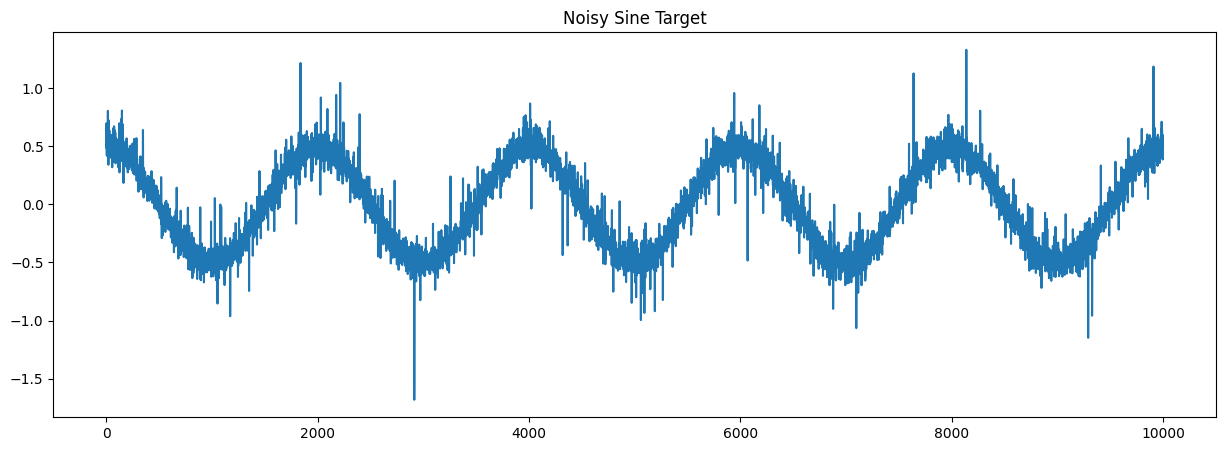

In [38]:
large_wave = WaveGen(size=10_000).linear_phase().cos().amp(.5).t_noise(std=.05, dof=3).sample(1).samples.squeeze(axis=0)
print(large_wave.shape)
plt.figure(figsize=(15,5))
plt.plot(large_wave)
plt.title('Noisy Sine Target')
plt.show()

In [39]:
# https://jamesmccaffrey.wordpress.com/2021/08/30/an-example-of-a-bayesian-neural-network-using-pytorch/bayesian_neural_network_demo/
class SineBayesianRegressor(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, prior_mu=0, prior_sigma=.1):
        super(SineBayesianRegressor, self).__init__()
        self.input = bnn.BayesLinear(prior_mu=prior_mu, prior_sigma=prior_sigma, in_features=input_size, out_features=hidden_size)
        self.output = bnn.BayesLinear(prior_mu=prior_mu, prior_sigma=prior_sigma, in_features=hidden_size, out_features=output_size)
        return
        
    def forward(self, x):
        x = self.input(x)
        x = torch.relu(x)
        x = self.output(x)
        return x

In [40]:
def train(
    model, 
    dataset,
    n_epochs=1000,
    batch_size=64,
    criterion=torch.nn.MSELoss(),
    optimizer=torch.optim.RMSprop,
    early_stop_patience=0,
    test_full=True,
    print_=False,
):
    optimizer = optimizer(model.parameters())
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    if early_stop_patience:
        patience = 0
        model_buffer = None
        loss_buffer = torch.tensor(float('inf'))

    items = list()
    for epoch in range(n_epochs):
        for train_sample, test_sample in dataloader:
            optimizer.zero_grad()
            sample = model(train_sample)
            
            loss = criterion(sample, test_sample)       
            loss.backward()
            optimizer.step()

#             test_output = model(test_original)
#             test_loss = criterion(test_output, test_denoised)

#             if p and not epoch % 10:
#                 print('Train Loss', train_loss.item())
#                 print('Test Loss', test_loss.item())
#                 p = False
                
#         if test_full:
#             train_original, train_denoised = train_dataset[:]
#             test_original, test_denoised = test_dataset[:]
#             train_output = model(train_original)
#             train_loss = criterion(train_output, train_denoised)
#             test_output = model(test_original)
#             test_loss = criterion(test_output, test_denoised)
#             if early_stop_patience:
#                 if test_loss > loss_buffer:
#                     patience += 1
#                     if patience >= early_stop_patience:
#                         items = items[:-early_stop_patience]
#                         model = model_buffer
#                         break
#                 else:
#                     model_buffer = model
#                     loss_buffer = test_loss
#         elif early_stop_patience:
#             warnings.warn('Early Stopping Patience argument unused, full data evaluation at end of epochs is disabled. \n Set test_full to True for early stopping.')
        
        items.append(loss.item())
    return model, items

def plot_loss(loss, title='', step=1):
    plt.figure(figsize=(16,8))
    colors = sns.color_palette('Spectral', 8)
    sns.lineplot(loss[::step], dashes=False, color=colors[0], label='Train MSE')
    if title:
        plt.title(title)
    plt.legend()
    plt.show()
    return

In [ ]:
input_sizes = [700,800,900]
sizes = [950,1000,1100]
hidden_sizes = [64, 128, 256, 512, 2048]

columns = ['input_size','output_size','hidden_size','loss']
total_i = np.prod([len(input_sizes),len(sizes),len(hidden_sizes)])
rows = list()
n_epochs = 30
batch_size = 32
for i, (input_size, size, hidden_size) in enumerate(itertools.product(input_sizes, sizes, hidden_sizes)):
    if size <= input_size: continue
        
    print('Input Set', i + 1, 'out of', total_i, end='\n')
    print(input_size, size, hidden_size, sep='|')
    output_size = size - input_size
    
    dataset = TorchTimesplitDataset(torch.from_numpy(large_wave), split=input_size, size=size)    
    
    model = SineBayesianRegressor(
        input_size, 
        output_size, 
        hidden_size, 
        prior_mu=0, 
        prior_sigma=.1,
    ).double()
    
    try:
        model, loss = train(
            model, 
            dataset, 
            n_epochs=n_epochs, 
            batch_size=batch_size, 
            test_full=True,
            early_stop_patience=5,
        )
    except RuntimeError as re:
        warnings.warn(str(re))
        continue
        
    if not len(loss):
        print('Missing loss')
        continue
    rows.append((input_size, output_size, hidden_size, loss[-1]))

Input Set 1 out of 45
700|950|64
Input Set 2 out of 45
700|950|128
Input Set 3 out of 45
700|950|256


In [34]:
grid_df = pd.DataFrame(rows, columns=columns)
assert grid_df.shape[1] == len(columns), f'{grid_df.shape[1]} != {len(columns)}'
grid_df.columns = columns
grid_df.to_csv(f'training_io_{pd.to_datetime("today").strftime("%Y-%m-%d:%H")}.csv')
display(grid_df)

,input_size,output_size,hidden_size,loss


In [35]:
for col in columns[:-1]:
    plt.figure(figsize=(8,5))
    sns.barplot(data=grid_df, x=col, y='loss')
    plt.show()

ValueError: Could not interpret input 'test_loss'

<Figure size 800x500 with 0 Axes>